# Nuclei segmentation


Have problems loading the full res image, crashes the kernel, instead take a smaller part of the image and run segmentation on.

More details in:

https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html

https://github.com/broadinstitute/Tangram/blob/master/tangram_tutorial.ipynb

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import os,sys

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

print(f"tangram=={tg.__version__}")

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.5.2 pandas==1.1.0 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.2
tangram==1.0.0


## Create the image container

Takes quite a while to load, the file is only 136M large, but python uses over 33Gb memory and the kernel crashes.

Load smaller proportion of the image instead.

In [2]:
#img_path = "../../../spatial/rawdata/images/Donor_1/201006_P17401_V10J29-111_AM.A1-Spot000001.jpg" 
# 136M
# original image, crashes on load
# WARNING: Image size (2267283456 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
# 47616 × 47616 pixels
# need to add in:

from PIL import Image
Image.MAX_IMAGE_PIXELS = 3000000000  
# still crashes

#sf = 1
#img = sq.im.ImageContainer(img_path, scale=sf)
#img.show()
# still crashes kernel!

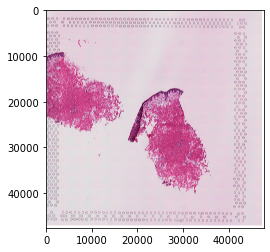

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img_path = "../../../spatial/rawdata/images/Donor_1/201006_P17401_V10J29-111_AM.A1-Spot000001.jpg" 

from PIL import Image
Image.MAX_IMAGE_PIXELS = 3000000000  
    
# Read Images
img = mpimg.imread(img_path)
  
# Output Images
plt.imshow(img)


# DecompressionBombError: Image size (2,267,283,456 pixels) exceeds limit of 178,956,970 pixels, could be decompression bomb DOS attack.


In [4]:
print(img.dtype)
print(img.shape)
print(type(img))

uint8
(47616, 47616, 3)
<class 'numpy.ndarray'>


In [5]:
# take smaller part of the image

sub = img[17000:25000,25000:33000,:] 
#sub = img[17000:40000,17000:38000,:] # covers the section

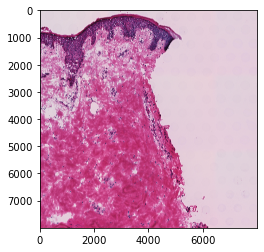

In [6]:
plt.imshow(sub)

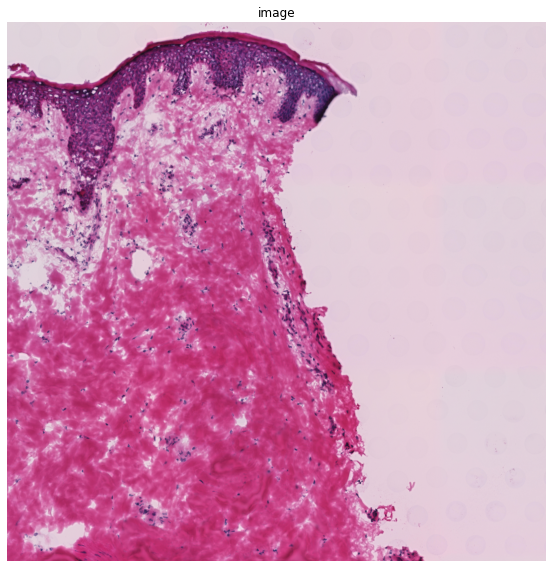

In [7]:
# now load the array into squidpy container.
# crashes kernel if full image is loaded
# also with just the section

sf = 1
crop = sq.im.ImageContainer(sub, scale=sf)
crop.show()

# also kills the kernel

# Add in ST data

Read in ST data for that section

In [8]:
sample = "Donor1_Skin"
input_dir = "../../../deconv/inputs/"
indir = os.path.join(input_dir,"st_data",sample)   
    

fh = open(os.path.join(indir, "rawdata_path.csv"),"r+")
raw_path = fh.read()
fh.close()
  
raw_path = raw_path.strip()
raw_path = "../" + raw_path
print(raw_path) 

../../../spatial/rawdata//Donor_1/P17401_1001


In [9]:
adata_st = sc.read_visium(raw_path, library_id = sample)
adata_st.var_names_make_unique()

# read in the filtered barcodes
barcodes = pd.read_csv(os.path.join(indir, "barcodes.csv"), header = None)

# subset
adata_st = adata_st[adata_st.obs.index.isin(barcodes[0]),:]
adata_st

adata_st

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


View of AnnData object with n_obs × n_vars = 1378 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
adata_st.obsm["spatial"][:,0].min()

ArrayView(3519)

In [11]:
# Subset for same region
adata_st.obsm
# 47616, 47616
# sub = img[17000:25000,25000:33000,:] 

y = adata_st.obsm["spatial"][:,0]
x = adata_st.obsm["spatial"][:,1]


sel = (x > 17000) & (x < 25000) & (y > 25000) & (y < 33000)

print(sum(sel.tolist()))

adata_sub = adata_st[sel,:].copy()
adata_sub

138


AnnData object with n_obs × n_vars = 138 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

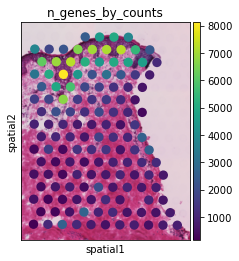

In [12]:
sc.pp.calculate_qc_metrics(adata_sub, percent_top=None, log1p=False, inplace=True)

adata_sub.obs
sc.pl.spatial(adata_sub, color = ["n_genes_by_counts"])


# Nuclei segmentation

For segmentation of H&E images, following more or less this tutorial: brain_segment_hne.html




In [13]:
crop

ImageContainer[shape=(8000, 8000), layers=['image']]

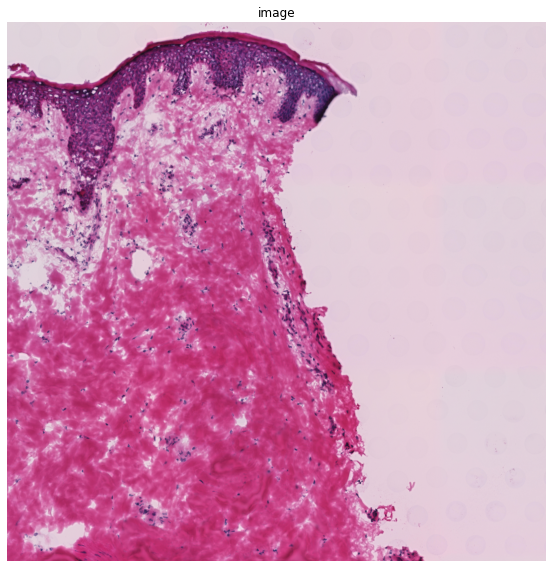

In [14]:
crop.show(layer="image")



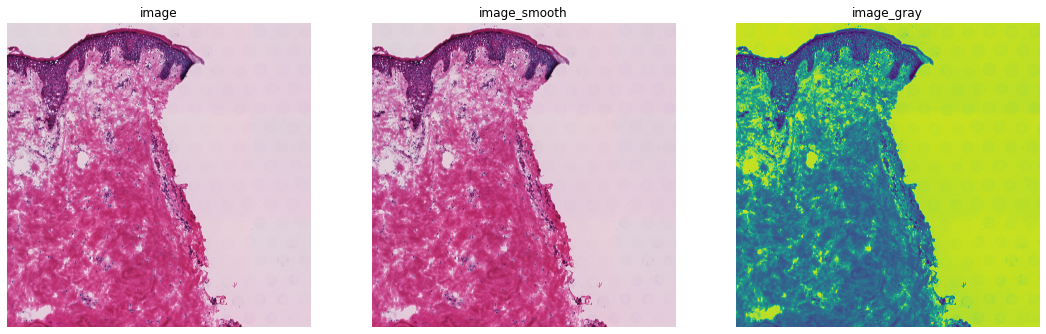

In [15]:
# smooth image
sq.im.process(crop, layer="image", method="smooth")
sq.im.process(crop, layer="image", method="gray")
#sq.im.process(crop, layer="image", method="smooth", sigma=4)

# plot the result
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
for layer, ax in zip(["image", "image_smooth", "image_gray"], axes):
    crop.show(layer, ax=ax)
    ax.set_title(layer)
    



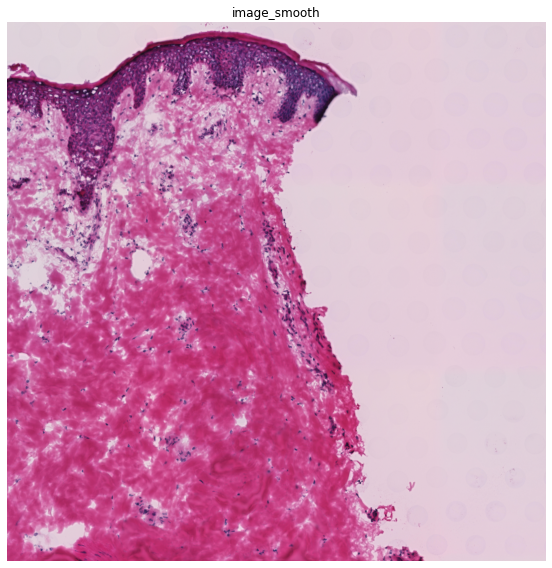

In [16]:
crop.show("image_smooth")
# smoother image clearly looks to blurred

In [17]:
crop

ImageContainer[shape=(8000, 8000), layers=['image', 'image_gray', 'image_smooth']]

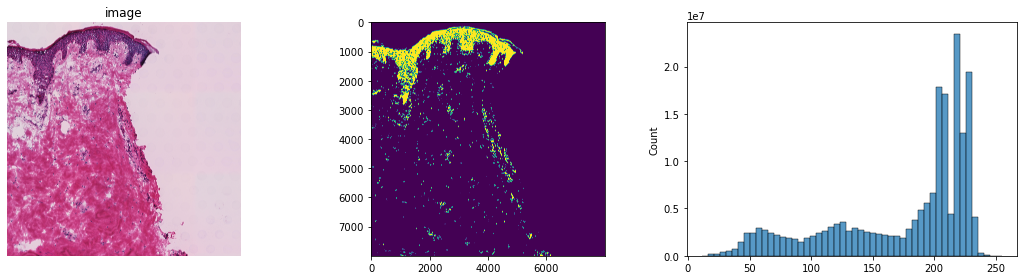

In [18]:
import seaborn as sns

# image_smooth just looks blurred, us orignial image

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
crop.show("image", cmap="gray", ax=axes[0])
axes[1].imshow(crop["image"][:, :, 0, 0] < 150)
_ = sns.histplot(np.array(crop["image"]).flatten(), bins=50, ax=axes[2])
plt.tight_layout()


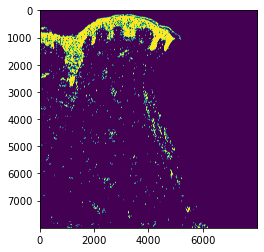

In [19]:
plt.imshow(crop["image"][:, :, 0, 0] < 150)

Judging from the histogram in the third plot we decide on a cutoff for the intensities (in this example 0.6) and in the middle image, all pixels above that level are shown.

In [20]:
sq.im.segment(crop, layer="image", method="watershed", thresh=150, geq=False)



ImageContainer[shape=(8000, 8000), layers=['image', 'image_gray', 'image_smooth', 'segmented_watershed']]
Number of segments in crop: 8736


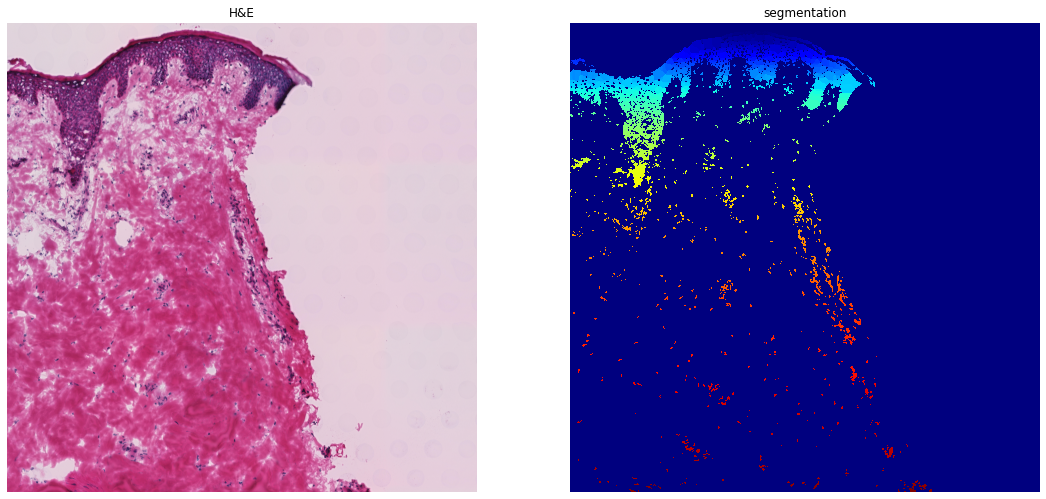

In [21]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_watershed']))}")

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)
crop.show("image", cmap="gray", ax=axes[0])
_ = axes[0].set_title("H&E")
crop.show("segmented_watershed", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

In [22]:
# the coordinates in adata object is still in range from before.
# ValueError: Expected `height` to be in interval `[0, 8000]`, found `22243`.
#sel = (x > 17000) & (x < 25000) & (y > 25000) & (y < 33000)


y = adata_sub.obsm["spatial"][:,0] 
x = adata_sub.obsm["spatial"][:,1] 

print(str(x.min()) + "-" + str(x.max()))
print(str(y.min()) + "-" + str(y.max()))

x = x - 17000
print(str(x.min()) + "-" + str(x.max()))
y = y - 25000
print(str(y.min()) + "-" + str(y.max()))

adata_sub.obsm["spatial"][:,0] = y
adata_sub.obsm["spatial"][:,1] = x


17188-24803
25040-30855
188-7803
40-5855


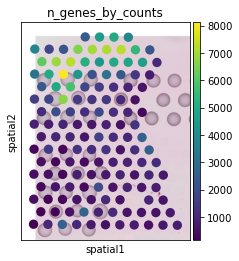

In [23]:
# now plotting is in wrong place in image.
# revert back after tangram

sc.pl.spatial(adata_sub, color = ["n_genes_by_counts"])
#sf = adata_sub.uns["spatial"]["Donor1_Skin"]["scalefactors"]["tissue_hires_scalef"]

In [24]:
# in tutorial with DAPI stain

# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_sub,
    crop,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:10<00:00, 13.46/s]


In [25]:
adata_sub.obsm["image_features"]["segmentation_label"].value_counts()

0      23
2       8
7       6
8       6
1       5
4       5
6       5
9       5
19      4
5       4
28      3
18      3
16      3
27      3
3       3
12      2
14      2
15      2
65      2
59      2
10      2
17      2
87      2
35      2
26      2
13      2
11      1
20      1
22      1
24      1
209     1
29      1
82      1
151     1
147     1
144     1
136     1
116     1
110     1
109     1
102     1
97      1
86      1
77      1
160     1
75      1
74      1
68      1
50      1
49      1
43      1
42      1
39      1
37      1
36      1
31      1
Name: segmentation_label, dtype: int64

In [26]:
adata_sub.obsm['image_features']

segmentation_label  \
AAACGAGACGGTTGAT-1                   2   
AACGTGCGAAAGTCTC-1                   0   
AAGAGCTCTTTATCGG-1                   0   
AAGAGGCATGGATCGC-1                  14   
AAGATTGGCGGAACGT-1                 136   
...                                ...   
TTCTGCGGGTTAGCGG-1                  29   
TTGAATATGGACTTTC-1                  12   
TTGGGCGGCGGTTGCC-1                  20   
TTGTAAGGCCAGTTGG-1                  22   
TTGTTGTGTGTCAAGA-1                  49   

                                                segmentation_centroid  
AAACGAGACGGTTGAT-1               [[1324.0, 5432.0], [1701.0, 5055.0]]  
AACGTGCGAAAGTCTC-1                                               [[]]  
AAGAGCTCTTTATCGG-1                                               [[]]  
AAGAGGCATGGATCGC-1  [[1611.0, 5604.475818251057], [1613.5976140404...  
AAGATTGGCGGAACGT-1  [[4573.516569107252, 546.5202073639675], [4568...  
...                                                               ...  
TTCTGCGGGTTAGCGG-1  [[1597.0, 7587.952645845502], [1606.7740058322...  
TTGAATATGGACTTTC-1  [[456.0, 4911.431351606453], [486.208071204063...  
TTGGGCGGCGGTTGCC-1  [[490.4614260571384, 2766.446222749346], [470....  
TTGTAAGGCCAGTTGG-1  [[1935.0, 1122.3300312566234], [1976.974643387...  
TTGTTGTGTGTCAAGA-1  [[758.7734156991996, 3041.320111189203], [761....  

[138 rows x 2 columns]

In [27]:
# revert back to oringinal tissue position for plotting onto the highres image

adata_sub.obsm["spatial"][:,0] = adata_sub.obsm["spatial"][:,0] + 25000
adata_sub.obsm["spatial"][:,1] = adata_sub.obsm["spatial"][:,1] + 17000


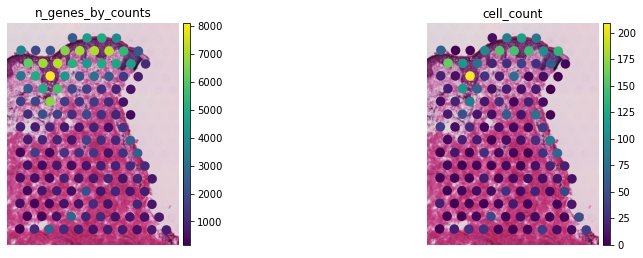

In [28]:
adata_sub.obs["cell_count"] = adata_sub.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_sub, color=["n_genes_by_counts", "cell_count"], frameon=False, library_id = sample)

Predicted number of cells vs counts/genes

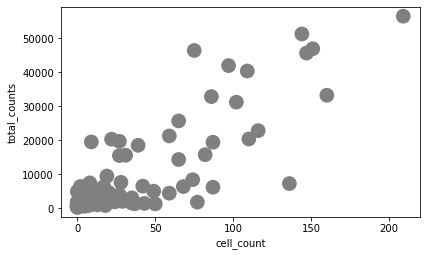

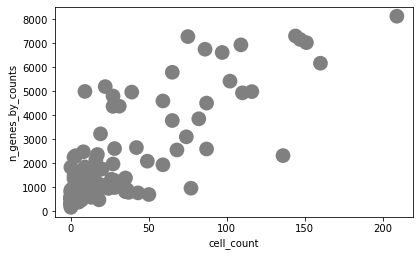

In [29]:
sc.pl.scatter(adata_sub, "cell_count", "total_counts")
sc.pl.scatter(adata_sub, "cell_count", "n_genes_by_counts")

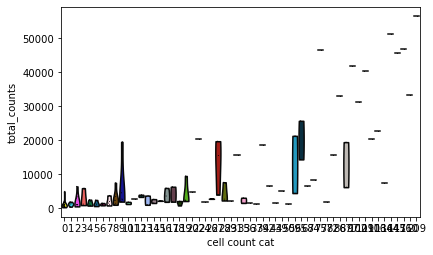

In [30]:
# violins can only be done with categorical values, not numeric.

adata_sub.obs["cell_count_cat"] = adata_sub.obs["cell_count"].astype("category")

sc.pl.violin(adata_sub,"total_counts", "cell_count_cat")


## Load SC data


In [31]:
sc_dir = '../../scRNAseq/results/'
sc_path = os.path.join(input_dir, "sc_data", "s1_subsampled.h5ad")
adata_sc = sc.read_h5ad(sc_path)
adata_sc

AnnData object with n_obs × n_vars = 9120 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot'
    var: 'features'

In [32]:
# has normalized counts in .X and counts in raw.X
# OBS! The raw matrix has numericals instead of gene names as var.index
adata_sc.raw.var.index = adata_sc.var.index

In [33]:
# Revert back to raw matrix to have all genes
adata_sc = adata_sc.raw.to_adata()

In [34]:
adata_sc.obs['cl.annot'].value_counts()

VE             385
Mast-cell      381
Granular-II    380
Mono-Mac       378
Th             376
FB-II          376
Spinous-I      374
MEL            374
Granular-I     373
Basal-I        368
PC-vSMC        368
FB-III         367
Spinous-II     367
FB-IV          367
Mac            367
Basal-II       366
NK-cell        366
Spinous-III    364
FB-I           352
DC             312
B-cell         292
Basal-III      290
Basal-IV       286
LE             283
LC             237
Mono-DC        235
Schwann        136
Name: cl.annot, dtype: int64

In [35]:
deg_path = os.path.join(input_dir, "sc_data", "degs_fc0.5_pval0.01.txt")
genes = pd.read_csv(deg_path, header=None) 
genes

0
0         KRT1
1        KRT10
2       KRTDAP
3         DMKN
4      LGALS7B
...        ...
5116    R3HCC1
5117  RNASEH2C
5118   IGF2BP2
5119     GPR17
5120     PDS5B

[5121 rows x 1 columns]

In [36]:
print(genes.isin(adata_st.var_names).sum())
print(genes.isin(adata_sc.var_names).sum())


genes = list(genes[0])

0    5121
dtype: int64
0    5121
dtype: int64


## Run Tangram 

In [37]:
tg.pp_adatas(adata_sc, adata_sub, genes=genes)

INFO:root:4916 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:15711 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [38]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_sub,
    mode="constrained",
    target_count=adata_sub.obs.cell_count.sum(),
    density_prior=np.array(adata_sub.obs.cell_count) / adata_sub.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 4916 genes and customized density_prior in constrained mode...


Score: 0.323, KL reg: 0.811, Count reg: 919.945, Lambda f reg: 1885.824
Score: 0.633, KL reg: 0.003, Count reg: 1.188, Lambda f reg: 286.461
Score: 0.642, KL reg: 0.001, Count reg: 0.231, Lambda f reg: 72.306
Score: 0.643, KL reg: 0.001, Count reg: 0.081, Lambda f reg: 39.880
Score: 0.644, KL reg: 0.001, Count reg: 0.004, Lambda f reg: 29.360
Score: 0.644, KL reg: 0.001, Count reg: 0.055, Lambda f reg: 24.624
Score: 0.645, KL reg: 0.001, Count reg: 0.036, Lambda f reg: 22.113
Score: 0.645, KL reg: 0.001, Count reg: 0.004, Lambda f reg: 20.620
Score: 0.645, KL reg: 0.001, Count reg: 0.088, Lambda f reg: 19.525
Score: 0.645, KL reg: 0.001, Count reg: 0.121, Lambda f reg: 18.790


INFO:root:Saving results..


In [39]:
tg.project_cell_annotations(ad_map, adata_sub, annotation="cl.annot")


INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [40]:
adata_sub.obs = pd.concat([adata_sub.obs, adata_sub.obsm["tangram_ct_pred"]], axis=1)


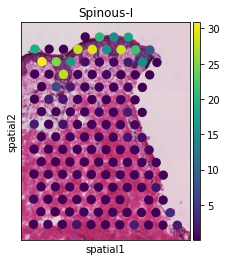

In [41]:
adata_sub.obsm["tangram_ct_pred"]["Spinous-I"]

sc.pl.spatial(
    adata_sub,
    color=["Spinous-I"],
)

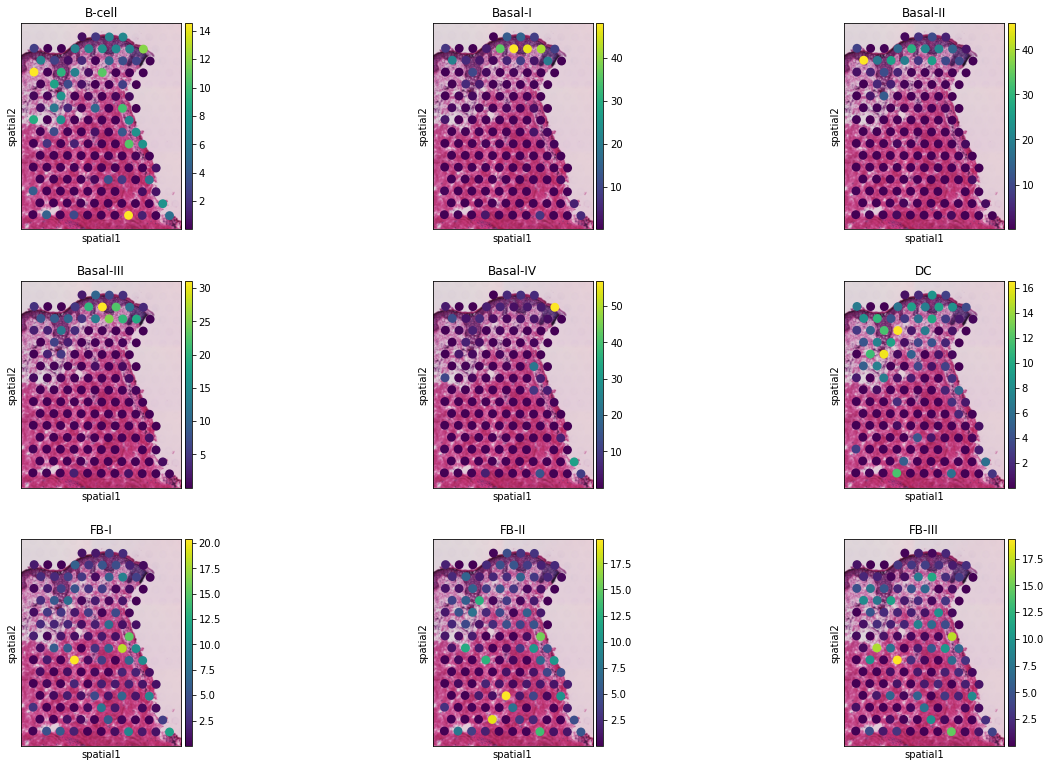

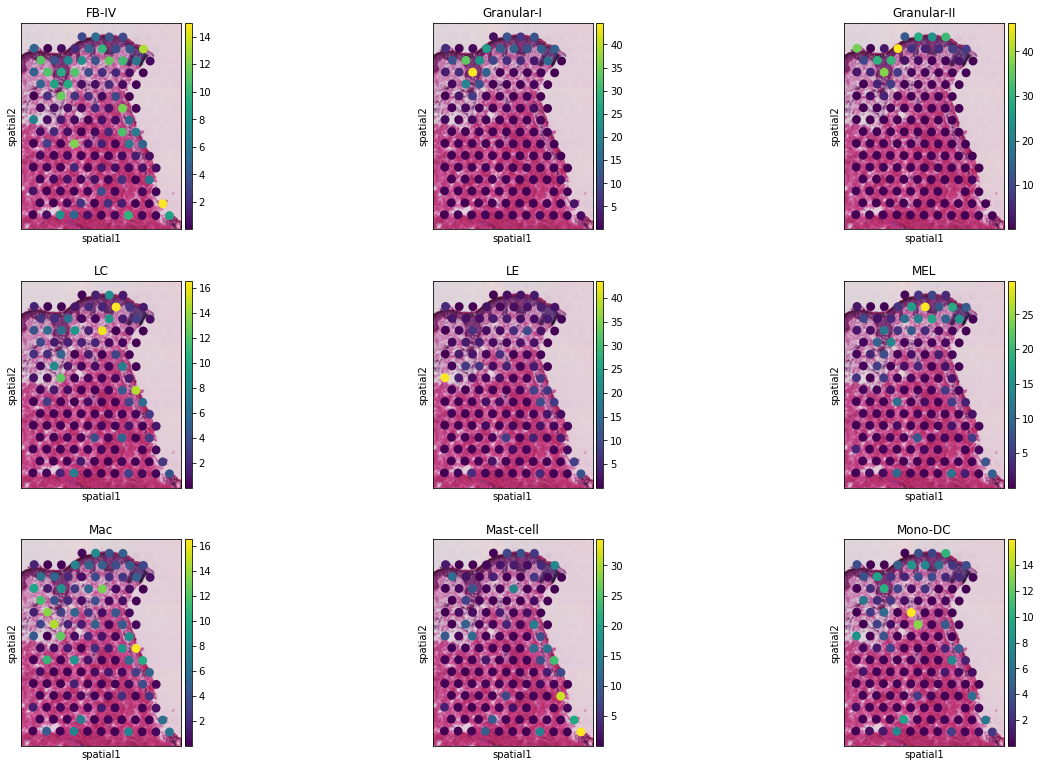

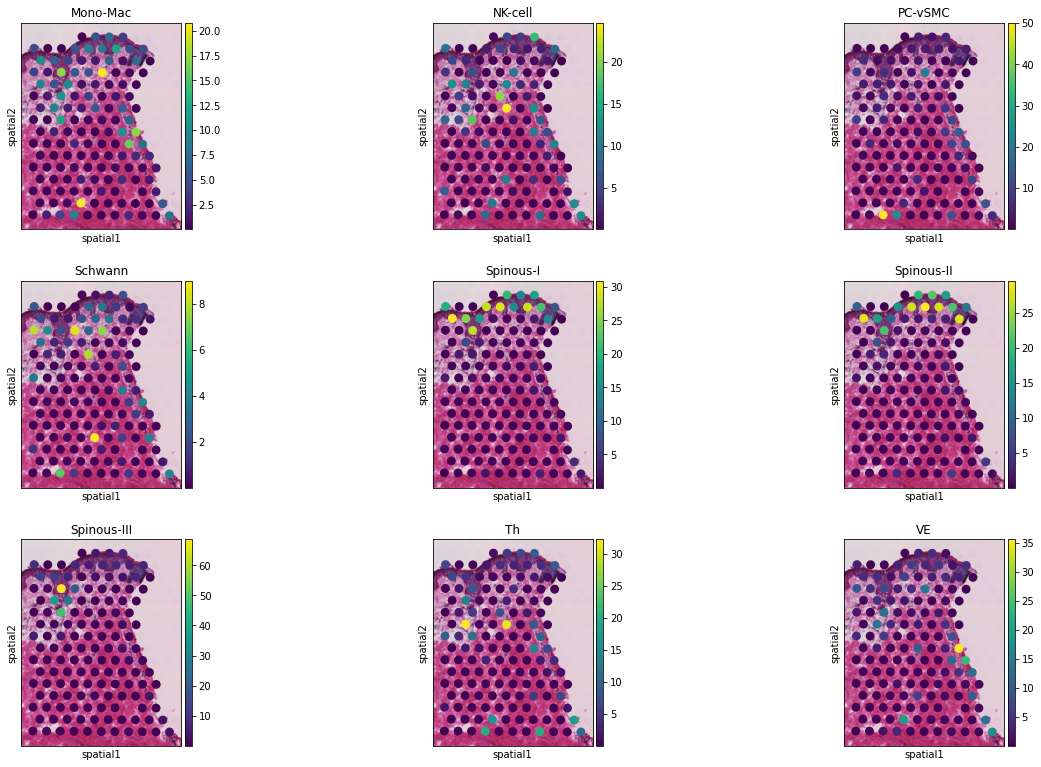

In [42]:
celltypes = adata_sc.obs['cl.annot'].unique()
celltypes = sorted(celltypes)

# plot 9 at a time (have 27 celltypes)
sc.pl.spatial(
    adata_sub,
    color=celltypes[:9],
    ncols=3,
)
sc.pl.spatial(
    adata_sub,
    color=celltypes[9:18],
    ncols=3,
)
sc.pl.spatial(
    adata_sub,
    color=celltypes[18:27],
    ncols=3,
)

In [43]:
tg.create_segment_cell_df(adata_sub)

INFO:root:cell segmentation dataframe is saved in `uns` `tangram_cell_segmentation` of the spatial AnnData.
INFO:root:spot centroids is saved in `obsm` `tangram_spot_centroids` of the spatial AnnData.


In [44]:
adata_sub.uns["tangram_cell_segmentation"].head()


spot_idx       y            x             centroids
0  AAACGAGACGGTTGAT-1  1324.0  5432.000000  AAACGAGACGGTTGAT-1_0
1  AAACGAGACGGTTGAT-1  1701.0  5055.000000  AAACGAGACGGTTGAT-1_1
2  AACGTGCGAAAGTCTC-1     NaN          NaN                   NaN
3  AAGAGCTCTTTATCGG-1     NaN          NaN                   NaN
4  AAGAGGCATGGATCGC-1  1611.0  5604.475818  AAGAGGCATGGATCGC-1_0

In [45]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_sub,
    annotation="cl.annot",
)

INFO:root:spatial cell count dataframe is saved in `obsm` `tangram_ct_count` of the spatial AnnData.


In [46]:
adata_sub.obsm["tangram_ct_count"].head()

x      y  cell_n  \
AAACGAGACGGTTGAT-1  22243  26512       2   
AACGTGCGAAAGTCTC-1  22738  25055       0   
AAGAGCTCTTTATCGG-1  22239  25931       0   
AAGAGGCATGGATCGC-1  22751  26799      14   
AAGATTGGCGGAACGT-1  17713  29743     136   

                                                            centroids  Th  \
AAACGAGACGGTTGAT-1       [AAACGAGACGGTTGAT-1_0, AAACGAGACGGTTGAT-1_1]   0   
AACGTGCGAAAGTCTC-1                                                 []   0   
AAGAGCTCTTTATCGG-1                                                 []   0   
AAGAGGCATGGATCGC-1  [AAGAGGCATGGATCGC-1_0, AAGAGGCATGGATCGC-1_1, A...   0   
AAGATTGGCGGAACGT-1  [AAGATTGGCGGAACGT-1_0, AAGATTGGCGGAACGT-1_1, A...   4   

                    Basal-I  DC  FB-II  LE  MEL  ...  LC  Spinous-I  B-cell  \
AAACGAGACGGTTGAT-1        0   0      0   0    0  ...   0          0       0   
AACGTGCGAAAGTCTC-1        0   0      0   0    0  ...   0          0       0   
AAGAGCTCTTTATCGG-1        0   0      0   0    0  ...   0          0       0   
AAGAGGCATGGATCGC-1        0   1      2   1    1  ...   0          0       0   
AAGATTGGCGGAACGT-1        4   2      2   1    4  ...   0          3       9   

                    Basal-II  VE  NK-cell  Spinous-III  Basal-IV  Basal-III  \
AAACGAGACGGTTGAT-1         0   0        0            0         0          0   
AACGTGCGAAAGTCTC-1         0   0        0            0         0          0   
AAGAGCTCTTTATCGG-1         0   0        0            0         0          0   
AAGAGGCATGGATCGC-1         0   1        0            0         0          0   
AAGATTGGCGGAACGT-1         1   4        6            1        43          2   

                    Schwann  
AAACGAGACGGTTGAT-1        0  
AACGTGCGAAAGTCTC-1        0  
AAGAGCTCTTTATCGG-1        0  
AAGAGGCATGGATCGC-1        0  
AAGATTGGCGGAACGT-1        2  

[5 rows x 31 columns]

In [47]:
adata_segment = tg.deconvolve_cell_annotations(adata_sub)


In [48]:
adata_segment.obs.head()

adata_segment.obs.x.max()
adata_segment.obs.y.max()

6016.2032162979285

In [49]:
adata_segment.obsm["spatial"][:,0] = adata_segment.obsm["spatial"][:,0] + 25000
adata_segment.obsm["spatial"][:,1] = adata_segment.obsm["spatial"][:,1] + 17000

[<AxesSubplot:title={'center':'cluster'}, xlabel='spatial1', ylabel='spatial2'>]

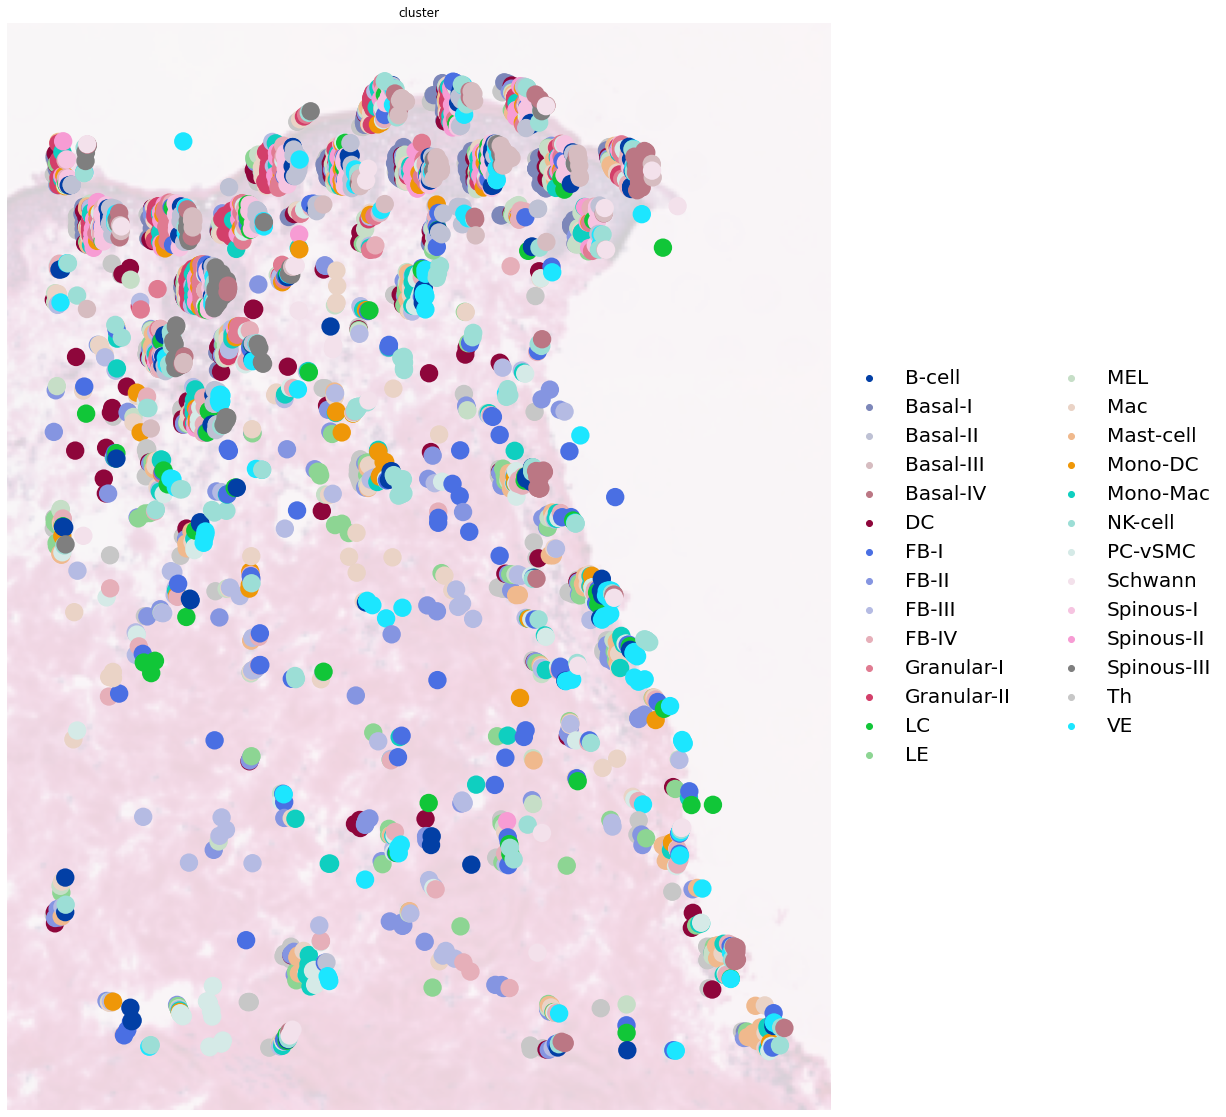

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    library_id = sample,
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
#    scale_factor = sf,
    ax=ax,
)

In [55]:
adata_sub.obs["MEL"].max()

29.817010078683097